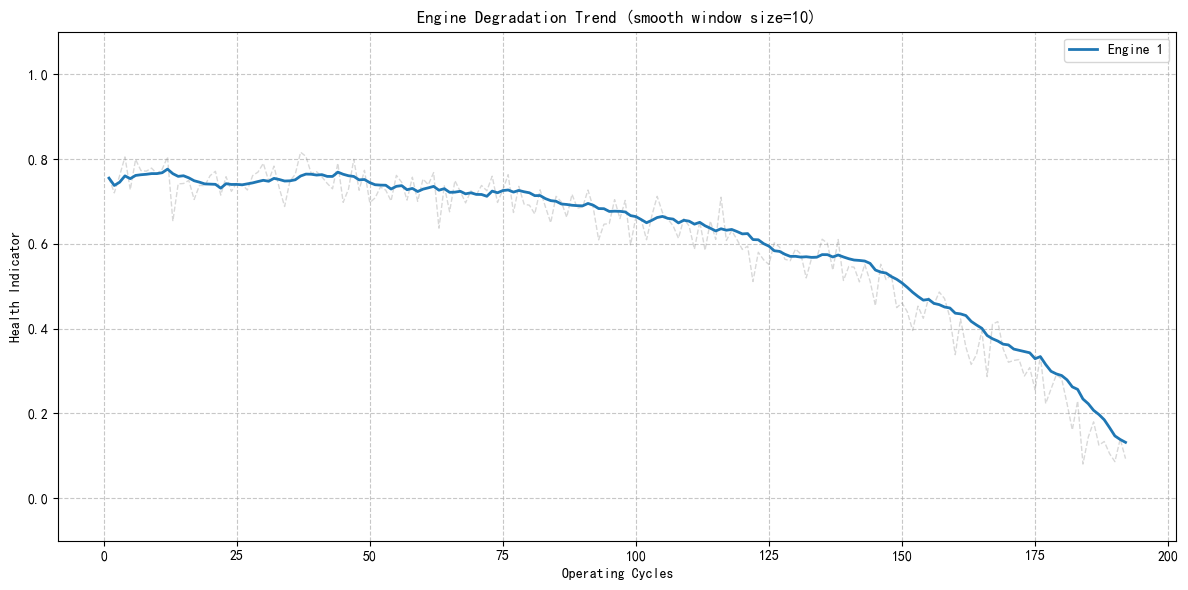

In [18]:
#  导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
# 配置
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False
# 数据加载与预处理
def load_and_preprocess():
    # 读取原始数据
    df_train = pd.read_csv(r"data\train_FD001.txt", sep=' ', header=None)
    df_test = pd.read_csv(r"data\test_FD001.txt", sep=' ', header=None)
    df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header=None)

    # 定义列名
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 
                'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 
                'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    
    # 清洗数据
    df_train = df_train[list(range(26))].dropna(axis=1, how='all')
    df_train.columns = col_list
    df_test = df_test[list(range(26))].dropna(axis=1, how='all')
    df_test.columns = col_list

    # 筛选有效特征
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 
                    'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
    df_train = df_train[new_col_list]
    df_test = df_test[new_col_list]

    # 归一化处理（排除unit和时间列）
    scale_cols = new_col_list[2:]
    df_train[scale_cols] = minmax_scale(df_train[scale_cols])
    df_test[scale_cols] = minmax_scale(df_test[scale_cols])
    
    return df_train, df_test, df_RUL

def generate_health_indicator(train_df, test_df):
    # 选择关键传感器
    selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8',  'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21']

    # PCA融合
    pca = PCA(n_components=1)
    hi_train = pca.fit_transform(train_df[selected_sensors])
    hi_test = pca.transform(test_df[selected_sensors])

    # 归一化并反转方向
    train_df['HI'] = 1 - minmax_scale(hi_train)
    test_df['HI'] = 1 - minmax_scale(hi_test)

    # 添加滑动平均滤波
    window_size = 10  # ← 窗口大小
    train_df['HI_smooth'] = train_df.groupby('unit')['HI'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    test_df['HI_smooth'] = test_df.groupby('unit')['HI'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    return train_df, test_df

def visualize_health_indicator(df, engine_ids=None, title='Health Indicator Trend'):
    if engine_ids is None:
        engine_ids = df['unit'].unique()[:3]   
    plt.figure(figsize=(12, 6))
    
    for eng_id in engine_ids:
        engine_data = df[df['unit'] == eng_id]       
        # 绘制原始HI（半透明细线）
        plt.plot(engine_data['time'], engine_data['HI'],  color='gray', alpha=0.3, linewidth=1, linestyle='--')       
        # 绘制平滑HI（实线）
        plt.plot(engine_data['time'], engine_data['HI_smooth'], linewidth=2, label=f'Engine {eng_id}')
    
    plt.title(title + ' (smooth window size=10)')
    plt.xlabel('Operating Cycles')
    plt.ylabel('Health Indicator')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 加载数据
train_df, test_df, RUL_df = load_and_preprocess()
# 生成健康指标
train_df, test_df = generate_health_indicator(train_df, test_df)
# 可视化
visualize_health_indicator(train_df, [1], 'Engine Degradation Trend')

In [19]:
# 序列生成函数
def prepare_sequences(df, seq_length=30, is_train=True):
    engines = df['unit'].unique()
    X, y = [], []
    
    for eng in engines:
        eng_data = df[df['unit'] == eng]
        hi = eng_data['HI_smooth'].values
        
        if is_train:
            # 生成训练序列和标签
            rul = eng_data['time'].max() - eng_data['time']  # 计算剩余寿命
            for i in range(len(hi)-seq_length):
                X.append(hi[i:i+seq_length])
                y.append(rul.iloc[i+seq_length])
        else:
            # 生成测试序列（取最后seq_length个点）
            if len(hi) >= seq_length:
                X.append(hi[-seq_length:])
            else:
                # 不足部分用第一个值填充
                padding = np.full((seq_length - len(hi),), hi[0])
                X.append(np.concatenate([padding, hi]))
                
    return np.array(X), np.array(y) if is_train else np.array(X)
# 生成训练序列
seq_length = 30
X_train, y_train = prepare_sequences(train_df, seq_length)

# 标准化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)

# 划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
# 模型构建
class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.time_steps = input_shape[1]
        self.W = self.add_weight(name='time_weight', shape=(input_shape[-1], 1),initializer='glorot_normal')
        initial_bias = np.linspace(0.5, 1.5, self.time_steps).reshape(1, -1, 1)
        # 时间位置权重，后期时间步权重更大
        self.b = self.add_weight(name='position_bias',shape=(1, self.time_steps, 1),initializer=tf.constant_initializer(initial_bias))
        super().build(input_shape)
    
    def call(self, x):
        # 内容得分 [batch, time, 1]
        content_score = K.dot(x, self.W)       
        # 位置得分自动广播到 [batch, time, 1]
        position_score = self.b       
        # 合并得分 [batch, time, 1]
        e = content_score + position_score      
        # 沿时间维度计算softmax [batch, time, 1]
        a = K.softmax(e, axis=1)        
        # 应用注意力权重 [batch, time, features]
        weighted = x * a  # 自动广播到特征维度       
        # 输出聚合结果 [batch, features]
        return K.sum(weighted, axis=1), a

# 构建模型
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # 128单元LSTM + Dropout
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(256, return_sequences=True))(x) 
    context, att_weights = TemporalAttention()(x)
    context = Dropout(0.25)(context)   
    outputs = Dense(1)(context)  
    model = Model(inputs, outputs)
    att_model = Model(inputs, att_weights)  
    return model, att_model

model, att_model = create_model((seq_length, 1))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 256)          133120    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 30, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 512)           0         
                                                                 
 temporal_attention_3 (Tempo  ((None, 512),            542 

Epoch 1/100
441/441 [==============================] - 76s 157ms/step - loss: 4348.2456 - mae: 51.8579 - val_loss: 2397.3040 - val_mae: 36.8189
Epoch 2/100
441/441 [==============================] - 67s 153ms/step - loss: 2182.5144 - mae: 35.4418 - val_loss: 1949.6935 - val_mae: 33.6101
Epoch 3/100
441/441 [==============================] - 51s 115ms/step - loss: 1924.8771 - mae: 32.8396 - val_loss: 1768.8287 - val_mae: 30.3578
Epoch 4/100
441/441 [==============================] - 47s 107ms/step - loss: 1960.3073 - mae: 32.8700 - val_loss: 1747.9261 - val_mae: 31.4013
Epoch 5/100
441/441 [==============================] - 47s 107ms/step - loss: 1917.0471 - mae: 32.7876 - val_loss: 1715.7516 - val_mae: 31.0361
Epoch 6/100
441/441 [==============================] - 46s 104ms/step - loss: 1889.4056 - mae: 32.4981 - val_loss: 1676.0073 - val_mae: 30.3466
Epoch 7/100
441/441 [==============================] - 47s 107ms/step - loss: 1794.8646 - mae: 31.2994 - val_loss: 1861.9198 - val_mae: 

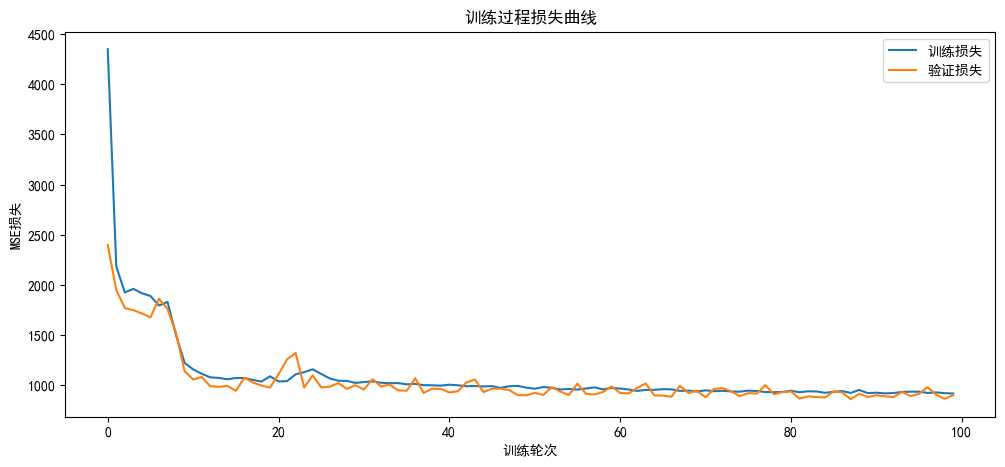

In [21]:
# 模型训练
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mse',metrics=['mae'])
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=100,batch_size=32,)

# 训练过程可视化
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('训练过程损失曲线')
plt.ylabel('MSE损失')
plt.xlabel('训练轮次')
plt.legend()
plt.show()

In [22]:
# 测试集预测准备
# 生成测试序列
X_test, _ = prepare_sequences(test_df, seq_length, is_train=False)
X_test = scaler.transform(X_test.reshape(-1,1)).reshape(X_test.shape)
# 获取真实RUL
test_rul = RUL_df[0].values
# 进行预测
y_pred = model.predict(X_test).flatten()

4/4 [==============================] - 2s 20ms/step


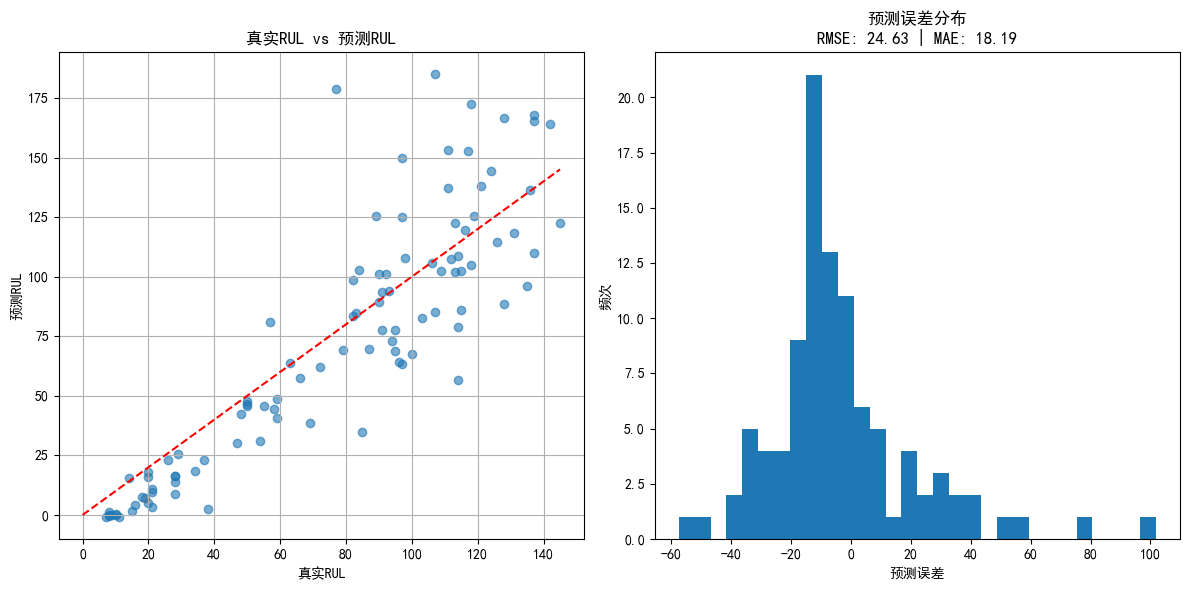

In [23]:
# 预测结果评估
def evaluate_predictions(true, pred):
    plt.figure(figsize=(12,6))   
    # 散点图
    plt.subplot(121)
    plt.scatter(true, pred, alpha=0.6)
    plt.plot([0, max(true)], [0, max(true)], '--r')
    plt.title('真实RUL vs 预测RUL')
    plt.xlabel('真实RUL')
    plt.ylabel('预测RUL')
    plt.grid(True)   
    # 误差分布
    plt.subplot(122)
    errors = pred - true
    plt.hist(errors, bins=30)
    plt.title('预测误差分布\nRMSE: {:.2f} | MAE: {:.2f}'.format(
        np.sqrt(mean_squared_error(true, pred)),
        mean_absolute_error(true, pred)
    ))
    plt.xlabel('预测误差')
    plt.ylabel('频次')
    
    plt.tight_layout()
    plt.show()
evaluate_predictions(test_rul, y_pred)

1/1 [==============================] - 2s 2s/step


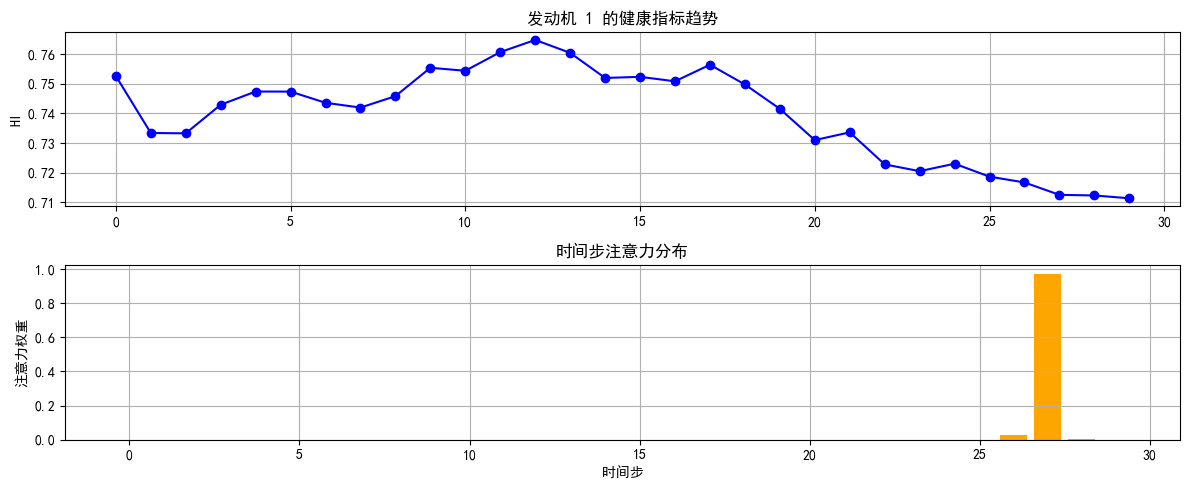

In [24]:

# %% [10] 注意力可视化
def plot_attention(engine_index):
    # 获取注意力权重
    sample = X_test[engine_index].reshape(1, seq_length, 1)
    weights = att_model.predict(sample)[0]  
    # 获取对应HI值
    hi = test_df[test_df['unit'] == engine_index+1]['HI_smooth'].values[-seq_length:]   
    plt.figure(figsize=(12,5))   
    # HI趋势
    plt.subplot(211)
    plt.plot(np.arange(seq_length), hi, 'b-o', label='HI值')
    plt.title(f'发动机 {engine_index+1} 的健康指标趋势')
    plt.ylabel('HI')
    plt.grid(True)   
    # 注意力权重
    plt.subplot(212)
    plt.bar(np.arange(seq_length), weights.squeeze(), color='orange')
    plt.xlabel('时间步')
    plt.ylabel('注意力权重')
    plt.title('时间步注意力分布')
    plt.grid(True)   
    plt.tight_layout()
    plt.show()
# 查看前3个发动机的注意力分布
for i in range(1):
    plot_attention(i)